In [20]:
%load_ext autoreload
%autoreload 2

import os
import sys
import argparse
import numpy as np
import pandas as pd 
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt


notebook_dir = os.getcwd()
target_path = os.path.abspath(os.path.join(notebook_dir, '../Python_Code'))
sys.path.append(target_path)
from dataGenerator import DataGeneratorUnified, DataGenerator

import util

# Constants
num_classes = 20
window_size = 50
epoch = 15

nr_subcarriers = NoOfSubcarrier = 242
window_size = 50
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
def create_datagenerator(train_environments=['Classroom', 'Office'], train_monitors=['m1', 'm2', 'm3'],):
  train_list_dataset_paths = []
  train_list_dataset_csvs = []
  val_list_dataset_paths = []
  val_list_dataset_csvs = []
  test_list_dataset_paths = []
  test_list_dataset_csvs = []


  for train_environment in train_environments:
    for train_monitor in train_monitors:
      train_dir = f'../Data/fine_grained/{train_environment}/80MHz/3mo/{train_monitor}/Slots/Train'
      test_dir = f'../Data/fine_grained/{train_environment}/80MHz/3mo/{train_monitor}/Slots/Test'
      train_csv = os.path.join(train_dir, 'train_set.csv')
      val_csv = os.path.join(train_dir, 'val_set.csv')
      test_csv = os.path.join(test_dir, 'test_set.csv')

      train_list_dataset_paths.append(train_dir)
      train_list_dataset_csvs.append(train_csv)
      val_list_dataset_paths.append(train_dir)
      val_list_dataset_csvs.append(val_csv)
      test_list_dataset_paths.append(test_dir)
      test_list_dataset_csvs.append(test_csv)


  nr_subcarriers = 242
  window_size = 50
  labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']

  train_gen = DataGeneratorUnified(train_list_dataset_paths, train_list_dataset_csvs, nr_subcarriers, len(labels), (window_size, nr_subcarriers, 2), batchsize=64, shuffle=True)
  val_gen = DataGeneratorUnified(val_list_dataset_paths, val_list_dataset_csvs, nr_subcarriers, len(labels), (window_size, nr_subcarriers, 2), batchsize=64, shuffle=True)
  test_gen = DataGeneratorUnified(test_list_dataset_paths, test_list_dataset_csvs, nr_subcarriers, len(labels), (window_size, nr_subcarriers, 2), batchsize=64, shuffle=False)

  return train_gen, val_gen, test_gen

train_gen, val_gen, test_gen  = create_datagenerator()

In [26]:
# Model Definition
def get_baseline_model(slice_size, classes, NoOfSubcarrier, fc1, fc2):
    model = models.Sequential()

    model.add(layers.Conv2D(64, (3, 3), padding='same', strides=2, input_shape=(slice_size, NoOfSubcarrier, 2)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.MaxPooling2D(pool_size=(2, 1)))
    model.add(layers.Flatten())
    model.add(layers.Dense(classes, activation='softmax'))

    model.summary()

    return model

# Model Definition
model = get_baseline_model(window_size, len(labels), NoOfSubcarrier, fc1=256, fc2=128)

# Compiling the Model
model.compile(optimizer=keras.optimizers.Adam(0.01), loss="categorical_crossentropy", metrics=["accuracy"])

/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 25, 121, 64)    │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 25, 121, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 25, 121, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 25, 121, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 25, 121, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 25, 121, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 25, 121, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 25, 121, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 25, 121, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 25, 121, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 25, 121, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 25, 121, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 25, 121, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 121, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 92928)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │     1,858,580 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,971,604 (7.52 MB)

 Trainable params: 1,971,092 (7.52 MB)

 Non-trainable params: 512 (2.00 KB)

In [27]:
def train_model(model, train_gen, val_gen, model_dir):
  learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=15, verbose=1, factor=0.5, min_lr=0.0001)
  checkpoint = ModelCheckpoint(model_dir, verbose=1, save_best_only=True)
  earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.05, patience=10, verbose=1)

  history = model.fit(
      x=train_gen,
      epochs=epoch,
      validation_data=val_gen,
      callbacks=[learning_rate_reduction, checkpoint, earlystopping],
      verbose=1
  )

  return history

# Training the Model
model_dir = '/home/diogo/work/SiMWiSense/Data/fine_grained/Classroom/80MHz/3mo//Classroom_m1m2m3.h5'
history = train_model(model, train_gen, val_gen, model_dir)

Epoch 1/15


/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5715/5715 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4996 - loss: 9.9834
Epoch 1: val_loss improved from inf to 0.21519, saving model to /home/diogo/work/SiMWiSense/Data/fine_grained/Classroom/80MHz/3mo//Classroom_m1m2m3.h5


5715/5715 ━━━━━━━━━━━━━━━━━━━━ 324s 56ms/step - accuracy: 0.4997 - loss: 9.9820 - val_accuracy: 0.9348 - val_loss: 0.2152 - learning_rate: 0.0100
Epoch 2/15
5715/5715 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9541 - loss: 0.1493
Epoch 2: val_loss improved from 0.21519 to 0.09276, saving model to /home/diogo/work/SiMWiSense/Data/fine_grained/Classroom/80MHz/3mo//Classroom_m1m2m3.h5


5715/5715 ━━━━━━━━━━━━━━━━━━━━ 319s 56ms/step - accuracy: 0.9541 - loss: 0.1493 - val_accuracy: 0.9715 - val_loss: 0.0928 - learning_rate: 0.0100
Epoch 3/15
5715/5715 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9719 - loss: 0.0909
Epoch 3: val_loss improved from 0.09276 to 0.08750, saving model to /home/diogo/work/SiMWiSense/Data/fine_grained/Classroom/80MHz/3mo//Classroom_m1m2m3.h5


5715/5715 ━━━━━━━━━━━━━━━━━━━━ 318s 56ms/step - accuracy: 0.9719 - loss: 0.0909 - val_accuracy: 0.9724 - val_loss: 0.0875 - learning_rate: 0.0100
Epoch 4/15
5714/5715 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9775 - loss: 0.0718
Epoch 4: val_loss improved from 0.08750 to 0.08716, saving model to /home/diogo/work/SiMWiSense/Data/fine_grained/Classroom/80MHz/3mo//Classroom_m1m2m3.h5


5715/5715 ━━━━━━━━━━━━━━━━━━━━ 295s 52ms/step - accuracy: 0.9775 - loss: 0.0718 - val_accuracy: 0.9755 - val_loss: 0.0872 - learning_rate: 0.0100
Epoch 5/15
5715/5715 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9812 - loss: 0.0602
Epoch 5: val_loss improved from 0.08716 to 0.08328, saving model to /home/diogo/work/SiMWiSense/Data/fine_grained/Classroom/80MHz/3mo//Classroom_m1m2m3.h5


5715/5715 ━━━━━━━━━━━━━━━━━━━━ 305s 53ms/step - accuracy: 0.9812 - loss: 0.0602 - val_accuracy: 0.9771 - val_loss: 0.0833 - learning_rate: 0.0100
Epoch 6/15
5714/5715 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9835 - loss: 0.0528
Epoch 6: val_loss improved from 0.08328 to 0.06033, saving model to /home/diogo/work/SiMWiSense/Data/fine_grained/Classroom/80MHz/3mo//Classroom_m1m2m3.h5


5715/5715 ━━━━━━━━━━━━━━━━━━━━ 294s 51ms/step - accuracy: 0.9835 - loss: 0.0528 - val_accuracy: 0.9824 - val_loss: 0.0603 - learning_rate: 0.0100
Epoch 7/15
5715/5715 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9857 - loss: 0.0473
Epoch 7: val_loss did not improve from 0.06033
5715/5715 ━━━━━━━━━━━━━━━━━━━━ 278s 49ms/step - accuracy: 0.9857 - loss: 0.0473 - val_accuracy: 0.9831 - val_loss: 0.0667 - learning_rate: 0.0100
Epoch 8/15
5714/5715 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9864 - loss: 0.0451
Epoch 8: val_loss improved from 0.06033 to 0.04597, saving model to /home/diogo/work/SiMWiSense/Data/fine_grained/Classroom/80MHz/3mo//Classroom_m1m2m3.h5


5715/5715 ━━━━━━━━━━━━━━━━━━━━ 267s 47ms/step - accuracy: 0.9864 - loss: 0.0451 - val_accuracy: 0.9872 - val_loss: 0.0460 - learning_rate: 0.0100
Epoch 9/15
5715/5715 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9873 - loss: 0.0419
Epoch 9: val_loss did not improve from 0.04597
5715/5715 ━━━━━━━━━━━━━━━━━━━━ 266s 46ms/step - accuracy: 0.9873 - loss: 0.0419 - val_accuracy: 0.9876 - val_loss: 0.0522 - learning_rate: 0.0100
Epoch 10/15
5714/5715 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9881 - loss: 0.0408
Epoch 10: val_loss did not improve from 0.04597
5715/5715 ━━━━━━━━━━━━━━━━━━━━ 264s 46ms/step - accuracy: 0.9881 - loss: 0.0408 - val_accuracy: 0.9850 - val_loss: 0.0724 - learning_rate: 0.0100
Epoch 11/15
5715/5715 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9888 - loss: 0.0395
Epoch 11: val_loss did not improve from 0.04597
5715/5715 ━━━━━━━━━━━━━━━━━━━━ 268s 47ms/step - accuracy: 0.9888 - loss: 0.0395 - val_accuracy: 0.9871 - val_loss: 0.0491 - learning_rate: 0.0100
Epoc

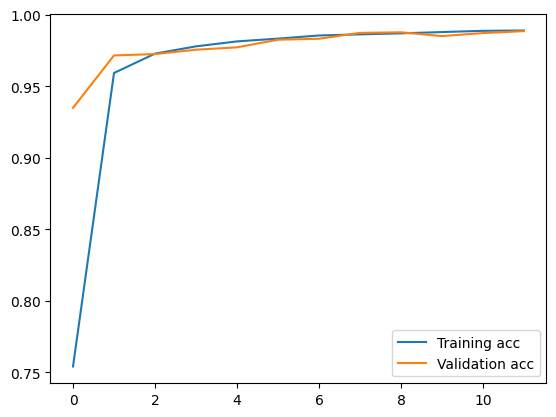

In [28]:
def plot_accuracy(history, train_dir):
    import matplotlib.pyplot as plt

    plt.plot(history.history["accuracy"], label="Training acc")
    plt.plot(history.history["val_accuracy"], label="Validation acc")
    plt.legend()
    plt.savefig(os.path.join(train_dir, 'train_val_accuracy.png'), dpi=300)
    plt.show()

# Plotting Accuracy
plot_accuracy(history, '/home/diogo/work/SiMWiSense/Data/fine_grained/Classroom/80MHz/3mo/')

In [29]:
# Evaluating Model
print("The validation accuracy is :", history.history['val_accuracy'])
print("The training accuracy is :", history.history['accuracy'])
print("The validation loss is :", history.history['val_loss'])
print("The training loss is :", history.history['loss'])

The validation accuracy is : [0.9348355531692505, 0.9714583158493042, 0.972390353679657, 0.9754605293273926, 0.9771052598953247, 0.9824342131614685, 0.9831030964851379, 0.9872149229049683, 0.9876205921173096, 0.9849780797958374, 0.9870613813400269, 0.9884539246559143]
The training accuracy is : [0.7540901303291321, 0.959202766418457, 0.9726979732513428, 0.977799654006958, 0.9812636971473694, 0.9832020998001099, 0.9853920340538025, 0.9861794710159302, 0.9868875741958618, 0.9877870678901672, 0.9886510372161865, 0.9888943433761597]
The validation loss is : [0.21519023180007935, 0.09275747090578079, 0.08750308305025101, 0.08716008067131042, 0.08327805250883102, 0.060328926891088486, 0.06670881062746048, 0.04597057029604912, 0.05223894119262695, 0.07241009920835495, 0.04911701753735542, 0.04723088815808296]
The training loss is : [2.0474672317504883, 0.13256387412548065, 0.08830269426107407, 0.07171964645385742, 0.06025945022702217, 0.054618898779153824, 0.04873182624578476, 0.0458286292850

In [30]:
model = load_model(model_dir)
final_loss, final_accuracy = model.evaluate(test_gen)
print('Test Loss: {}, Test Accuracy: {}'.format(final_loss, final_accuracy))

/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2336/2336 ━━━━━━━━━━━━━━━━━━━━ 109s 46ms/step - accuracy: 0.9606 - loss: 0.1977
Test Loss: 0.2296474725008011, Test Accuracy: 0.9523558020591736


2336/2336 ━━━━━━━━━━━━━━━━━━━━ 109s 47ms/step


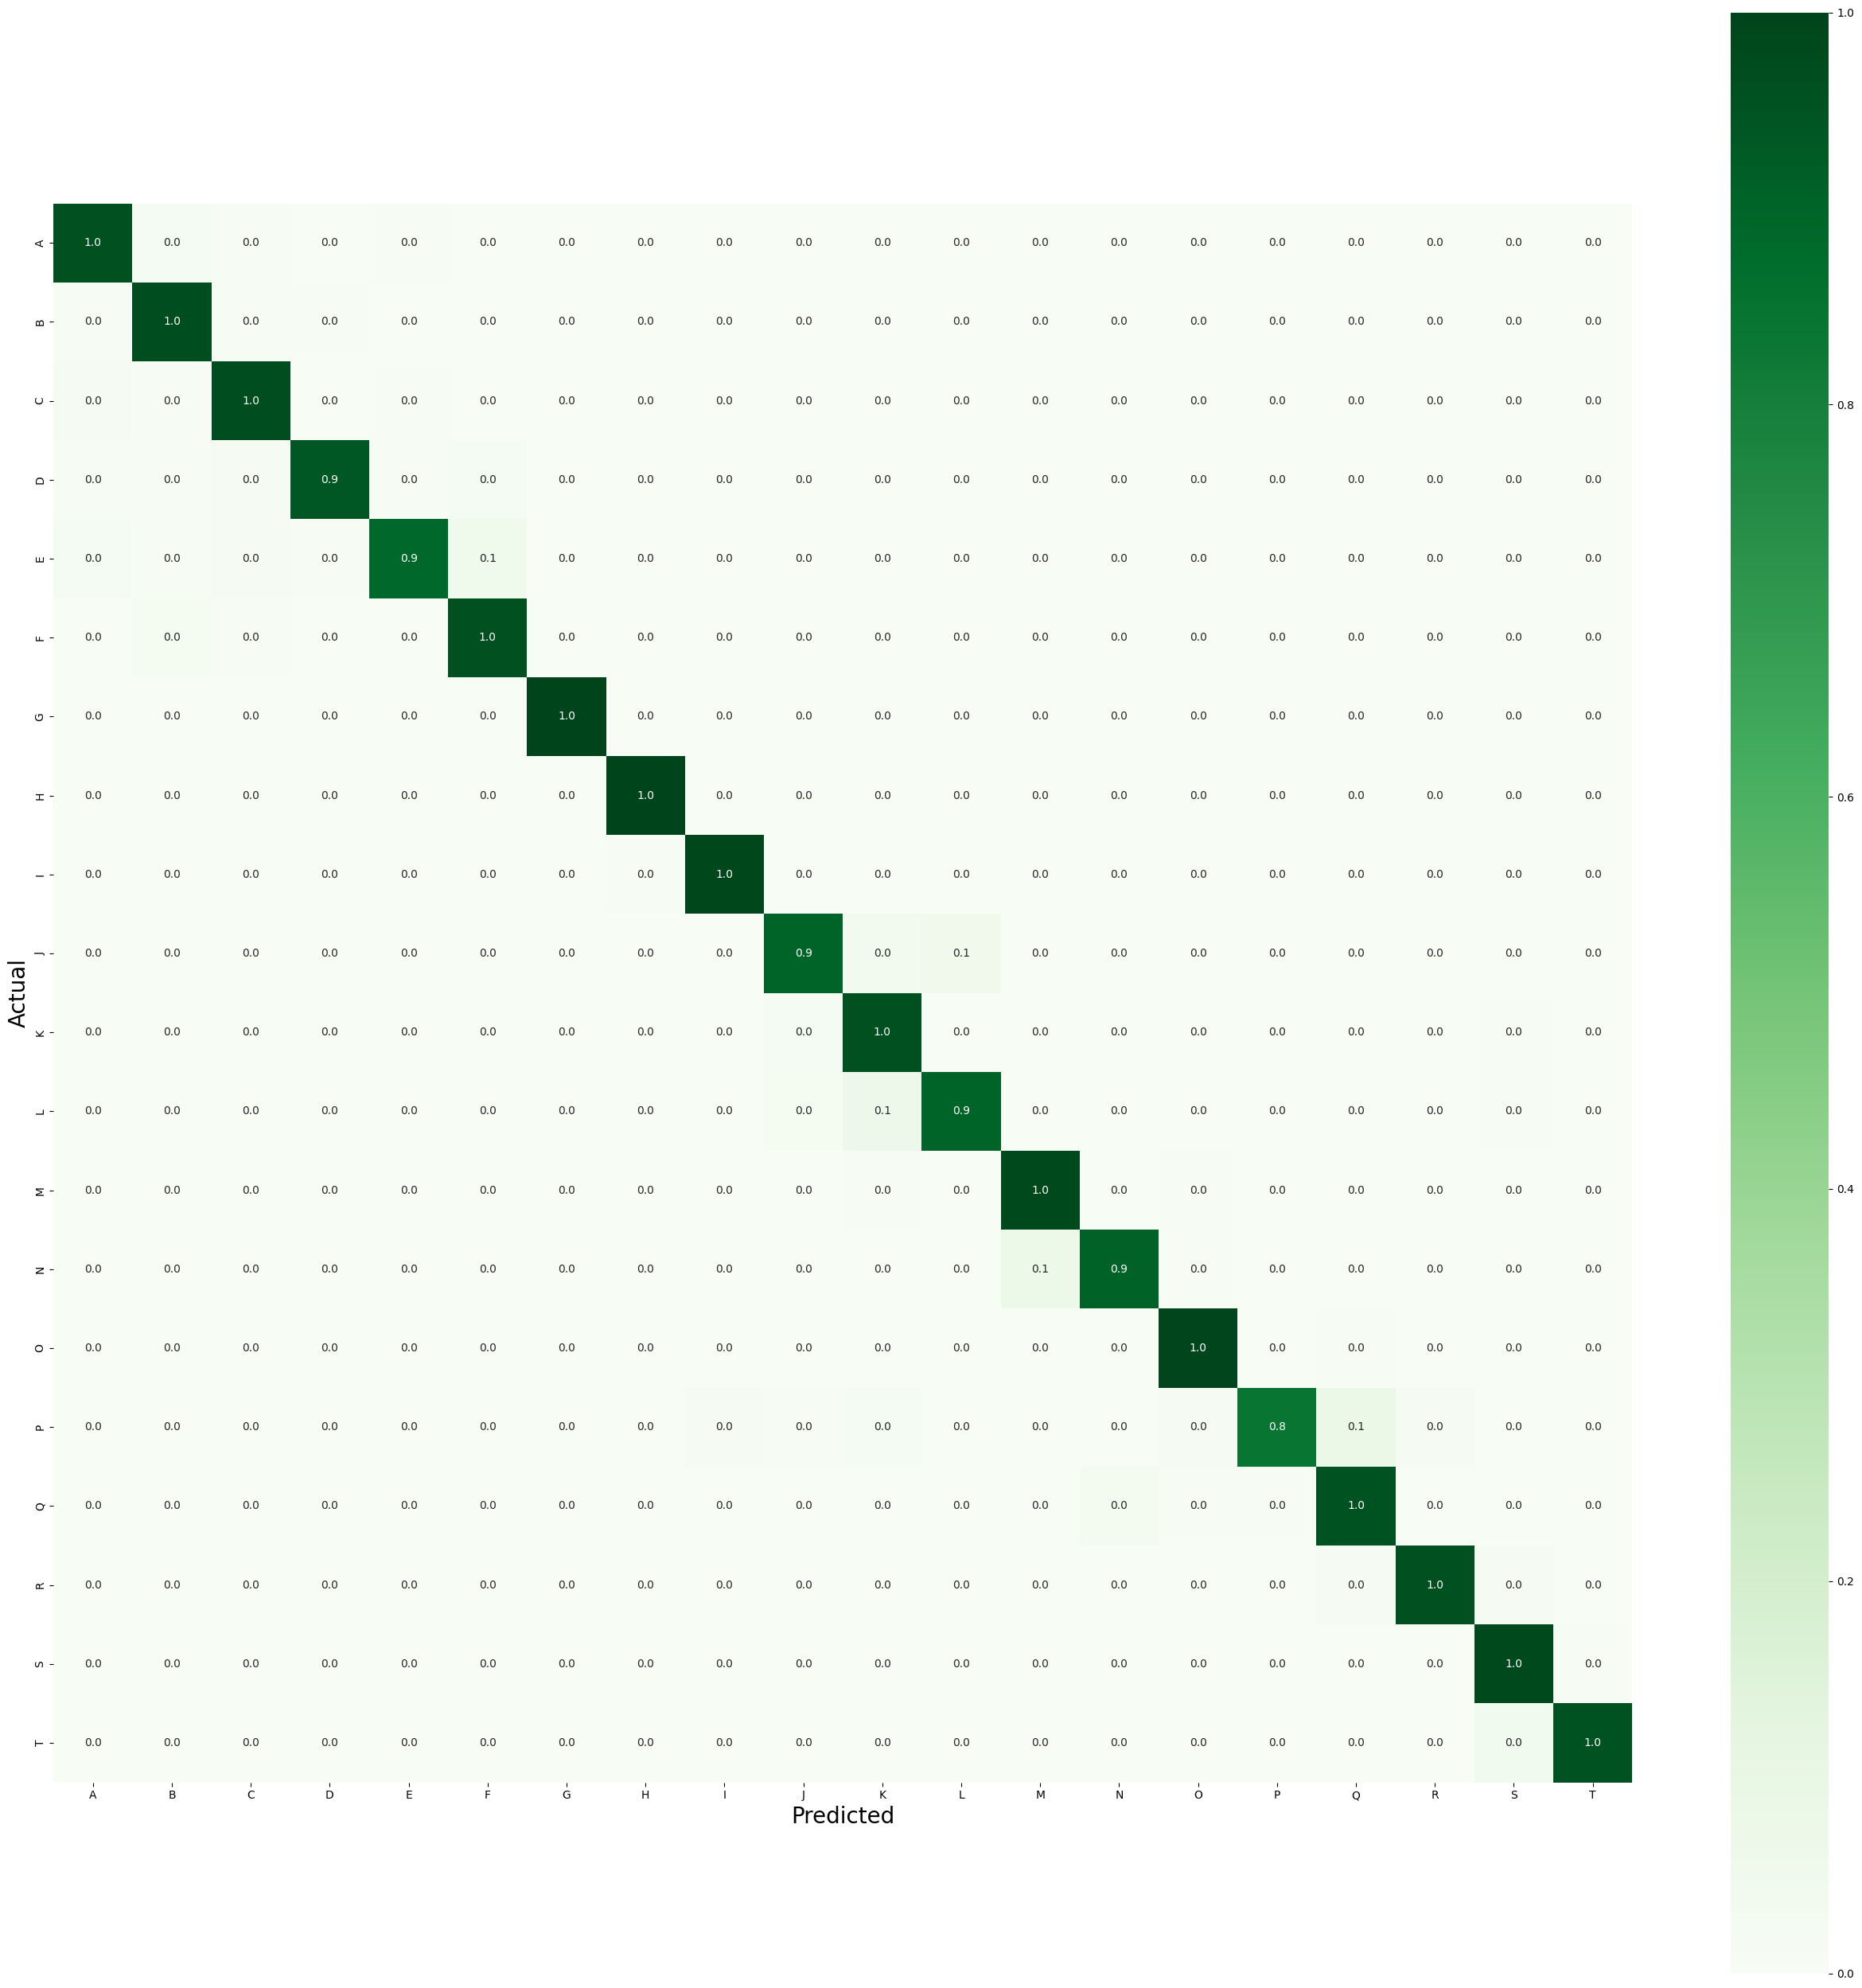

In [41]:
def evaluate_and_plot_confusion_matrix(model, test_gen, labels, train_dir):
    labels_array = np.array(test_gen.labels)
    # Y = test_gen.labels[test_gen.indexes]
    Y = labels_array[test_gen.indexes]
    Y_true = np.zeros(len(Y))

    for i, e in enumerate(Y):
        Y_true[i] = labels.index(e)

    Y_pred = model.predict(test_gen)
    Y_pred = np.argmax(Y_pred, axis=1)

    cm = confusion_matrix(Y_true[:len(Y_pred)], Y_pred, normalize='true')
    plt.figure(figsize=(32, 32))
    ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, fmt='.1f', square=True, xticklabels=labels, yticklabels=labels)
    ax.set_ylabel('Actual', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.savefig(os.path.join(train_dir, 'confusion_matrix.png'), dpi=300)
    plt.show()

evaluate_and_plot_confusion_matrix(model, test_gen, labels, '/home/diogo/work/SiMWiSense/Data/fine_grained/Classroom/80MHz/3mo/')
